In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
# This model is from https://github.com/patrik-ha/explainable-minichess
model = keras.models.load_model("6x6_model")

In [ ]:
# model.summary()

In [ ]:
from tensorflow.keras import backend as K
import numpy as np
from tqdm import tqdm

def get_all_resblock_outputs(boards):
    """Gets outputs of all intermediate layers in all residual blocks"""
    if len(boards.shape) == 3:
        boards = np.reshape(boards, (1, *boards.shape))

    # All inputs
    inp = model.input
    # All outputs of the residual blocks
    layer_names = [layer.name for layer in model.layers if "conv" in layer.name or "res" in layer.name]
    outputs = [layer.output for layer in model.layers if "conv" in layer.name or "res" in layer.name]
    functor = K.function([inp], outputs)

    BATCH_SIZE = 32
    all_layer_outs = []
    for i in tqdm(range(0, boards.shape[0], BATCH_SIZE)):
        layer_outs = functor([boards[i:i + BATCH_SIZE]])
        all_layer_outs.append(layer_outs)

    return all_layer_outs, layer_names

In [ ]:
LAYER_NAMES_TO_TARGET = ["conv2d_2"]

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score, balanced_accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import tensorflow.keras as keras


def perform_regression(points, targets, validation_points, validation_targets):
    return perform_logistic_regression(points, targets, validation_points, validation_targets)


def perform_logistic_regression(points, targets, validation_points, validation_targets):
    print("sd")
    inputs = keras.layers.Input((points.shape[1]))
    output = keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=keras.regularizers.L1(0.002))(inputs)

    model = keras.Model(inputs, output)
    model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001))

    model.fit(points, targets, validation_data=(validation_points, validation_targets), epochs=50)

    train_preds = model.predict(points) > 0.5
    val_preds = model.predict(validation_points) > 0.5
    print(binary_accuracy_metric(targets, train_preds))
    return binary_accuracy_metric(validation_targets, val_preds), model


def binary_accuracy_metric(targets, predictions):
    return 2 * (((targets == np.squeeze(predictions)).sum() / len(targets)) - 0.5)

In [ ]:
for CONCEPT_NAME in ["threat_my_queen"]:
    data = np.load("concept_datasets/{}.npz".format(CONCEPT_NAME))
    all_cases = data["cases"]
    all_labels = data["labels"]
    import os

    POSITIONS_TO_CONSIDER = 40000
    VALIDATION_POSITIONS = 10000

    USE_CACHED_PROBES = False
    SAVE_PROBES_IN_CACHE = True

    print("Getting outputs...")
    outputs, names = get_all_resblock_outputs(all_cases)
    # actual_outputs = predictor_model.predict(boards, id_vector_to_use)
    # Outputs blir returnert i batcher, må flette det sammen
    print("Merging outputs...")
    merged_outputs = []
    for output_batch in outputs:
        for i, output_layer in enumerate(output_batch):
            if len(merged_outputs) <= i:
                merged_outputs.append([])
            merged_outputs[i].extend(output_layer)

    for i, layer_output in enumerate(merged_outputs):
        merged_outputs[i] = np.array(merged_outputs[i])
    outputs = merged_outputs
    print("Outputs merged.")

    probes = {}
    for name in LAYER_NAMES_TO_TARGET:
        probe_path = "probes/6x6_{}-{}".format(CONCEPT_NAME, name)
        if USE_CACHED_PROBES and os.path.exists(probe_path):
            probe = keras.models.load_model(probe_path)
        else:
            LAYER_NUMBER_TO_TARGET = names.index(name)
            output = outputs[LAYER_NUMBER_TO_TARGET]
            points = output.reshape((output.shape[0], np.prod(output.shape[1:])))
            print(points.shape)
            print("Performing regression for layer {}".format(LAYER_NUMBER_TO_TARGET))
            score, probe = perform_regression(
                points[:POSITIONS_TO_CONSIDER],
                all_labels[:POSITIONS_TO_CONSIDER],
                points[POSITIONS_TO_CONSIDER:],
                all_labels[POSITIONS_TO_CONSIDER:]
            )

        if SAVE_PROBES_IN_CACHE and not USE_CACHED_PROBES:
            probe.save(probe_path)
        
        probes[name] = probe


In [ ]:
# This model was trained as a simple neural network classifier to classify the legality of a given position.
# It is used to provide a gradient signal to dissuade the maximisation process from generating illegal positions.

# In practice, the dataset used to train it was obtained by using the 6x6 chess model to generate a large amount
# of self-play games, and then randomly "corrupting" 50 % of them. This was done in such a way as to guarantee
# that the "corrupted" games were not legal positions, i.e removing kings from either position, placing both kings
# in check, placing pawns on the first and last ranks, while adding and removing a random amount of pieces.

# This method is alright, but in the future it might be cooler to do this again 
# with the intention to instead judge on "unlikeliness", meaning that it could be used
# to avoid "unlikely" (and therefore also illegal (?)) positions.
legality_model = keras.models.load_model("6x6_legality_checker", compile=False)

In [ ]:
# Did not end up using this, but could be cool to test out
class WeightedActivityByPiece(keras.regularizers.Regularizer):

    def __init__(self, l):
        self.l = l
        self.piece_weights = [1, 3, 3, 5, 9, 1]
        self.offset = 6

    def __call__(self, w):
        return self.l * tf.reduce_sum(
            self.piece_weights[0] * (w[:,:,:,0] + w[:,:,:,self.offset]) + 
            self.piece_weights[1] * (w[:,:,:,1] + w[:,:,:,1 + self.offset]) + 
            self.piece_weights[2] * (w[:,:,:,2] + w[:,:,:,2 + self.offset]) + 
            self.piece_weights[3] * (w[:,:,:,3] + w[:,:,:,3 + self.offset]) + 
            self.piece_weights[4] * (w[:,:,:,4] + w[:,:,:,4 + self.offset]) + 
            self.piece_weights[5] * (w[:,:,:,5] + w[:,:,:,5 + self.offset])
        )

In [ ]:
import larq
input_shape = all_cases.shape[1:3]

illegal_mask = np.ones((*input_shape, 12), dtype=np.bool8)
offset = 6
# No pawns on the first and last rank
illegal_mask[0, :, 0] = 0
illegal_mask[0, :, 0 + offset] = 0
illegal_mask[-1, :, 0] = 0
illegal_mask[-1, :, 0 + offset] = 0

# Don't add bishops when not used in 6x6
illegal_mask[:, :, 2] = 0
illegal_mask[:, :, 2 + offset] = 0

illegal_mask = tf.convert_to_tensor(illegal_mask, tf.float32)

def add_probe_to_model(model, probe_dict):
    names = list(probe_dict.keys())
    for layer in model.layers:
        layer.trainable = False
    # This layer + the added one is then the "maximized" input wrt. concept
    POSITION_PLANES = 12
    
    # Since the input is layer 1
    inp = keras.layers.Input(1)
    positive_mask_base = larq.layers.QuantDense(
        input_shape[0] * input_shape[1] * POSITION_PLANES, 
        use_bias=True, 
        kernel_quantizer=larq.quantizers.SteHeaviside(),
        name="trainable_pos",
        activation=None,
        kernel_initializer=keras.initializers.Zeros(), 
        bias_initializer=keras.initializers.Zeros(),
        kernel_constraint=larq.constraints.WeightClip(0)
    )(inp)

    negative_mask_base = larq.layers.QuantDense(
        input_shape[0] * input_shape[1], 
        use_bias=True, 
        kernel_quantizer=larq.quantizers.SteHeaviside(),
        name="trainable_neg",
        activation=None,
        kernel_initializer=keras.initializers.Zeros(), 
        bias_initializer=keras.initializers.Zeros(),
        kernel_constraint=larq.constraints.WeightClip(0)
    )(inp)
    positive_mask = keras.layers.Reshape((input_shape[0], input_shape[1], POSITION_PLANES))(positive_mask_base)
    positive_mask = keras.layers.Lambda(lambda outputs: keras.backend.clip(outputs, 0, 1), activity_regularizer=keras.regularizers.L1(0.005), name="positive_mask")(positive_mask)
    negative_mask = keras.layers.Reshape((input_shape[0], input_shape[1]))(negative_mask_base)
    negative_mask = keras.layers.Lambda(lambda outputs: keras.backend.clip(outputs, 0, 1), activity_regularizer=keras.regularizers.L1(0.005), name="negative_mask")(negative_mask)


    def fancy_add(a):
        mask, inputs = a
        inputs = inputs[:,:,:,:12]
        reduced = tf.reduce_sum(inputs, axis=-1)
        legal_mask = tf.expand_dims(reduced, -1)
        legal_mask = tf.repeat(legal_mask, 12, -1)
        mask -= legal_mask
        mask = tf.multiply(illegal_mask, mask)
        return keras.backend.clip(mask, 0, 1)
    
    def input_add(a):
        mask, inputs = a

        return mask + inputs[:,:,:,:12]
    

    def input_sub(a):

        board, neg_mask = a
        neg_mask = tf.expand_dims(neg_mask, -1)
        neg_mask = tf.repeat(neg_mask, 12, -1)
        return board[:,:,:,:12] - neg_mask
    
    # Burde fjerne tilfeller der den vil ha flere brikker på samme felt
    def mask_clear(board):
        non_crowded = tf.cast(tf.reduce_sum(board, axis=-1) <= 1, tf.float32)
        legal_mask = tf.expand_dims(non_crowded, -1)
        legal_mask = tf.repeat(legal_mask, 12, -1)
        return tf.multiply(board, legal_mask)


    # Trekk fra negative mask
    sub = keras.layers.Lambda(input_sub)((model.input, negative_mask))
    sub = keras.layers.Lambda(lambda outputs: keras.backend.clip(outputs, 0, 1), name="after_neg_mask")(sub)

    # Tvinge positive mask til å ikke legge til brikker på toppen av felt som er fylt inn (vil den ta bort brikker så kan den gjøre det gjennom negative mask)
    positive_mask = keras.layers.Lambda(fancy_add, name="fancy_add")((positive_mask, sub))

    # Legge til brikker
    sub = keras.layers.Lambda(input_add)((positive_mask, sub))
    sub = keras.layers.Lambda(lambda outputs: keras.backend.clip(outputs, 0, 1))(sub)
    sub = keras.layers.Lambda(mask_clear, name="new_board")(sub)

    # Legge til legality-checker
    legality_model.trainable = False
    legality_model._name = "legality_model"
    legality_x = legality_model(sub)
    # for layer in legality_model.layers[1:]:
    #     layer.trainable = False
    #     layer = layer(legality_x)
    #     legality_x = layer

    def input_meta(a):
        return a[:,:,:,12:]

    input_clip = keras.layers.Lambda(input_meta)(model.input)
    sub = keras.layers.Concatenate(axis=-1)([sub, input_clip])
    # sub = keras.layers.Reshape((shape[1], shape[2], 19))(sub)

    # some_model.summary()
    x = sub

    model_outputs = []
    last_res = None
    for i in range(1, len(model.layers)):
        layer = model.layers[i]
        if "add" in layer.name:
            x = model.layers[i]([last_res, x])
        else:
            x = model.layers[i](x)
        if "res" in layer.name:
            last_res = x
        name = x.name.split("/")[0]
        if name in names:
            layer_index = names.index(name)
            model_intermediate = keras.layers.Flatten()(x)
            output = keras.layers.Dense(1, activation="sigmoid", name="probe_out_{}".format(name))(model_intermediate)
            model_outputs.append(output)
        if len(model_outputs) == len(names):
            break

    full_model = keras.Model([model.inputs, inp], [*model_outputs, legality_x])
    for name, probe in probes.items():
        concept_output = full_model.get_layer("probe_out_{}".format(name))
        concept_output.set_weights(probe.layers[-1].get_weights())
        concept_output.trainable = False
    # full_model.get_layer("padding").trainable = False
    # full_model.summary()



    full_model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=larq.optimizers.Bop(threshold=1e-7, gamma=0.0000001))
    return full_model

def best_fit(model, cases, target, epochs=50):
    if len(cases.shape) == 3:
        cases = np.expand_dims(cases, 0)
    ones = np.ones(cases.shape[0])
    zeros = np.zeros(cases.shape[0])
    targets = np.full((len(probes), cases.shape[0]), target)
    model.fit([cases, ones], [*targets, zeros], epochs=epochs, batch_size=1)

altered_model = add_probe_to_model(model, probes)

In [ ]:
PIECE_LOOKUP = {
    'p': 0,
    'r': 3,
    'n': 1,
    'b': 2,
    'k': 5,
    'q': 4
}

INVERSE_PIECE_LOOKUP = {v: k for k, v in PIECE_LOOKUP.items()}

import chess

def visualize_board(output, override_to_play=0):
    if output.shape[-1] < 19:
        to_play = override_to_play
    else:
        to_play = int(output[0, 0, -1])
    board = chess.Board(None)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            for turn in [0, 1]:
                for piece in range(6):
                    if output[i, j, 6 * turn + piece]:
                        if to_play == 0:
                            file = chess.FILE_NAMES[output.shape[1] - j - 1]
                            rank = chess.RANK_NAMES[output.shape[0] - i - 1]
                            turn = (1 - turn)
                        else:
                            file = chess.FILE_NAMES[j]
                            rank = chess.RANK_NAMES[i]
                        board.set_piece_at(chess.parse_square(file + rank), chess.Piece(1 + piece, turn))
    return board
# visualize_board(to_consider)

In [ ]:
to_consider = all_cases[114]

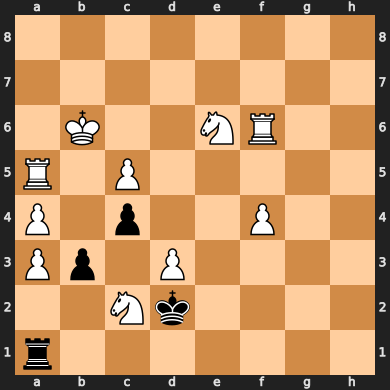

In [ ]:
visualize_board(to_consider)

In [ ]:
# TODO: might be nice with a notion of early stopping, if the criterias for the legality checker and the
# concept outputs are met. Until then, just retry this until both losses are low enough.
best_fit(altered_model, to_consider, 1, epochs=500)

Epoch 1/500
1/1 [==============================] - 0s 13ms/step - loss: 2.2450 - probe_out_conv2d_5_loss: 0.0020 - legality_model_loss: 1.5930
Epoch 2/500
1/1 [==============================] - 0s 12ms/step - loss: 2.2450 - probe_out_conv2d_5_loss: 0.0020 - legality_model_loss: 1.5930
Epoch 3/500
1/1 [==============================] - 0s 13ms/step - loss: 2.2450 - probe_out_conv2d_5_loss: 0.0020 - legality_model_loss: 1.5930
Epoch 4/500
1/1 [==============================] - 0s 12ms/step - loss: 2.2450 - probe_out_conv2d_5_loss: 0.0020 - legality_model_loss: 1.5930
Epoch 5/500
1/1 [==============================] - 0s 15ms/step - loss: 2.2450 - probe_out_conv2d_5_loss: 0.0020 - legality_model_loss: 1.5930
Epoch 6/500
1/1 [==============================] - 0s 12ms/step - loss: 2.2450 - probe_out_conv2d_5_loss: 0.0020 - legality_model_loss: 1.5930
Epoch 7/500
1/1 [==============================] - 0s 12ms/step - loss: 2.2450 - probe_out_conv2d_5_loss: 0.0020 - legality_model_loss: 1.5930

In [ ]:
def predict(model, cases):
    if len(cases.shape) == 3:
        cases = np.expand_dims(cases, 0)
    ones = np.ones(cases.shape[0])

    return model([cases, ones])
# predict(altered_model_after_neg, all_cases[0])

In [ ]:
predict(altered_model, to_consider)

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.89577013]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49790323]], dtype=float32)>]

In [ ]:
altered_model_inter = keras.Model(altered_model.inputs, altered_model.get_layer("new_board").output)
# altered_model_fancy = keras.Model(altered_model.inputs, altered_model.get_layer("fancy_add").output)
altered_model_pos = keras.Model(altered_model.inputs, altered_model.get_layer("positive_mask").output)
altered_model_neg = keras.Model(altered_model.inputs, altered_model.get_layer("negative_mask").output)
altered_model_after_neg = keras.Model(altered_model.inputs, altered_model.get_layer("after_neg_mask").output)

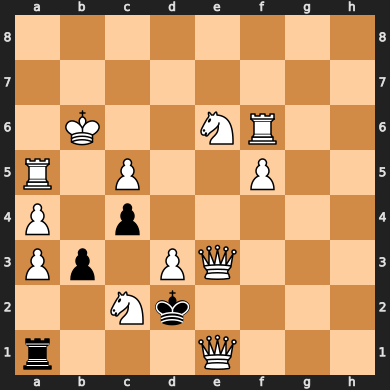

In [ ]:
visualize_board(predict(altered_model_inter, to_consider)[0], override_to_play=to_consider[0, 0, -1])

In [ ]:
PIECE_LOOKUP = {
    'p': 0,
    'r': 3,
    'n': 1,
    'b': 2,
    'k': 5,
    'q': 4
}

INVERSE_PIECE_LOOKUP = {v: k for k, v in PIECE_LOOKUP.items()}

def any_piece_at(state, i, j):
    for turn in [0, 1]:
        for ind in range(6):
            if state[i, j, turn * 6 + ind]:
                return ind, turn
    return -1, 0

def pseudo_fen(state):
    fen_string = ""
    files = "abcdefghi"
    ranks = "12345678"
    for rank in range(state.shape[0]):
        empties = 0
        for file in range(state.shape[1]):
            piece, color = any_piece_at(state, rank, file)
            if piece == -1:
                empties += 1
            else:
                if empties > 0:
                    fen_string += str(empties)
                    empties = 0
                piece_char = INVERSE_PIECE_LOOKUP[piece]
                if color == 1:
                    piece_char = piece_char.upper()
                fen_string += piece_char
        if empties > 0:
            fen_string += str(empties)
            empties = 0
        if rank != state.shape[0] - 1:
            fen_string += '/'

    return fen_string

In [ ]:
print(pseudo_fen(to_consider))
print(pseudo_fen(predict(altered_model_inter, to_consider)[0]))

r5/2Nk2/Pp1P2/P1p2P/R1P3/1K2NR
r3Q1/2Nk2/Pp1PQ1/P1p3/R1P2P/1K2NR
